In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats import entropy
from helpers import style
from helpers.afa import adaptive_filter
from itertools import groupby
from tqdm import tqdm
from collections import Counter
from itertools import combinations
from collections import defaultdict
import networkx as nx

from helpers.linkage import mutual_information_smooth
from helpers import nwsim
from helpers.metrics import *
from helpers.metrics import foote_novelty
import matplotlib.gridspec as gridspec

lda_path = '/home/rb/Documents/Data/models/lda/postwar-v3/'

style.load_style()

from helpers.dataloader import load

In [2]:
dists, dat, coltrans, keys = load()

# Modularity

Modularity is the extent to which a network is marked by communities. A rising modularity would be a first indication of topic-level specialization.

In [3]:
## Modularity
def get_mod(v):
    rij, ri, m = mutual_information_smooth(v)
    edf = pd.DataFrame(rij).stack().reset_index()
    edf = edf[edf[0] > 0]
    G = nx.from_pandas_edgelist(df = edf, source = 'level_0', target = 'level_1', edge_attr=0)
    comms = nx.community.louvain_communities(G,weight=0)
    return nx.community.quality.modularity(G,communities=comms)

## Degree
def get_ds(v):
    rij, ri, m = mutual_information_smooth(v)
    edf = pd.DataFrame(rij).stack().reset_index()
    edf = edf[edf[0] > 0]
    G = nx.from_pandas_edgelist(df = edf, source = 'level_0', target = 'level_1', edge_attr=0)
    return nx.density(G)

In [4]:
df_degree = dists.groupby(dists.index).apply(lambda g: get_ds(g.to_numpy())).reset_index(name='degree')
df_modul = dists.groupby(dists.index).apply(lambda g: get_mod(g.to_numpy())).reset_index(name='modularity')

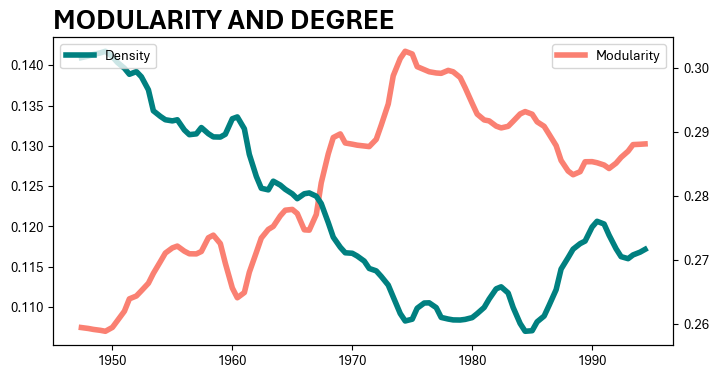

In [6]:
f, a = plt.subplots(1,1,figsize=(8,4))
a.plot(df_modul['index'], adaptive_filter(df_modul.modularity,span=35),color='salmon',label='Modularity',lw=4)
aa = a.twinx()
aa.plot(df_degree['index'], adaptive_filter(df_degree.degree,span=35),color='teal',label='Density',lw=4)
aa.legend(loc='upper left')
a.legend(loc='upper right')
a.set_title('MODULARITY AND DEGREE',fontweight='bold',fontsize=20,loc='left')

plt.savefig('figs/mod-degs.png',dpi=400)
plt.show()